In [544]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft2, ifft2
from scipy.ndimage import uniform_filter, gaussian_filter
import pandas as pd
from datetime import datetime
from matplotlib.colors import Normalize, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable


%matplotlib inline

"""
Create Your Own Lattice Boltzmann Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz

Simulate flow past cylinder
for an isothermal fluid

"""

#def poisson_solve(rho, conductivity, Nx, Ny):
#    # Fourier transform the charge density
#    rho_hat = fft2(rho)
#    
#    # Create the wave number grids
#    kx = np.fft.fftfreq(Nx).reshape((1, Nx))
#    ky = np.fft.fftfreq(Ny).reshape((Ny, 1))
#    kx, ky = np.meshgrid(kx, ky)
#    k_squared = kx**2 + ky**2
#
#    # Avoid division by zero at the zero frequency (set it to 1 to handle)
#    k_squared[0, 0] = 1.0
#
#    # Solve in Fourier space
#    phi_hat = rho_hat / (k_squared * conductivity)
#
#    # Transform back to real space
#    phi = np.real(ifft2(phi_hat))
#
#    # Compute electric field from potential gradient (E = -∇φ)
#    Ex = -np.gradient(phi, axis=1)  # derivative in x direction
#    Ey = -np.gradient(phi, axis=0)  # derivative in y direction
#
#    return Ex, Ey

######################################################### 
### 밀도 고정 로직: rho가 임계값 이하로 내려가면 고정시킴
########################################################
def phase_transition(F, rho, rho_lower_limit, rho_upper_limit, prob_fix=0.5):
    # 임계값 이하인 부분의 rho를 고정
    mask_below_limit = rho <= rho_lower_limit
    mask_above_limit = rho >= rho_upper_limit
    
    random_probabilities_below = np.random.rand(*rho.shape)
    random_probabilities_above = np.random.rand(*rho.shape)

    # rho가 낮은 임계값 이하일 때 확률적으로 고정
    rho_fixed = np.where(mask_below_limit & (random_probabilities_below < prob_fix), rho_lower_limit, rho)
    
    # Update F for the regions where rho is below rho_lower
    F[mask_below_limit, 1:9] = 0  # Set F components 1 to 8 to 0
    F[mask_below_limit, 0] = np.sum(F[mask_below_limit, 0:9], axis=1)  # Sum of components 1 to 8 into F[:,:,0]

    # # rho가 높은 임계값 이상일 때 확률적으로 고정
    # rho_fixed = np.where(mask_above_limit & (random_probabilities_above < prob_fix), rho_upper_limit, rho)

    # # Update F for the regions where rho is above rho_upper
    # F[mask_above_limit, 1:9] = 0  # Set F components 1 to 8 to 0
    # F[mask_above_limit, 0] = np.sum(F[mask_above_limit, 0:9], axis=1)  # Sum of components 1 to 8 into F[:,:,0]

    return rho_fixed


######################################################### 
### 스무딩 함수 (주로 ux, uy에 사용됨)
########################################################
def apply_global_smoothing(data, size=5, method='gaussian', sigma = 1, iterations  = 5):
    """
    Apply global smoothing to the entire 2D field with options for different methods.
    
    Args:
        data: 2D array to be smoothed (e.g., rho, ux, uy)
        size: smoothing window size for uniform filter (3x3 by default)
        method: smoothing method - 'uniform' for uniform filter, 'gaussian' for Gaussian filter
        sigma: standard deviation for Gaussian filter (used only when method='gaussian')
        iterations: number of times to apply the smoothing
    
    Returns:
        Smoothed data (2D array)
    """
    smoothed_data = data.copy()
    
    for _ in range(iterations):
        if method == 'uniform':
            smoothed_data = uniform_filter(smoothed_data, size=size)
        elif method == 'gaussian':
            smoothed_data = gaussian_filter(smoothed_data, sigma=sigma)
    
    return smoothed_data
    
######################################################### 
### 경계조건 함수. 반사율이 1-damping factor인 경계를 형성
########################################################
def apply_reflection_with_damping(F, damping_factor = 0.00001):
    """
    Apply reflection at boundaries with momentum damping.
    Args:
        F: Distribution function to be modified.
        damping_factor: Factor by which velocity is reduced after reflection.
        idxs: Indexes of velocity directions.
        cxs: x-components of velocity directions.
        cys: y-components of velocity directions.
    """
    # top boundary reflection
    F[:, 0, [6, 7, 8]] = F[:, 0, [4, 3, 2]] * (1 - damping_factor)
    F[:, 0, 0] = (F[:, 0, 4]+F[:, 0, 3]+F[:, 0, 2])*damping_factor
    # bottom boundary reflection
    F[:, -1, [2, 3, 4]] = F[:, -1, [8, 7, 6]] * (1 - damping_factor)
    F[:, -1, 0] = (F[:, -1, 8]+F[:, -1, 7]+F[:, -1, 6])*damping_factor

    # left boundary reflection
    F[0, :, [1, 2, 8]] = F[0, :, [5, 6, 4]] * (1 - damping_factor)
    F[0, :, 0] = (F[0, :, 5]+F[0, :, 6]+F[0, :, 4])*damping_factor

    # right boundary reflection
    F[-1, :, [4, 5, 6]] = F[-1, :, [8, 1, 2]] * (1 - damping_factor)
    F[-1, :, 0] = (F[-1, :, 8]+F[-1, :, 1]+F[-1, :, 2])*damping_factor

    #edge condition
    # Reflective boundary conditions at the corners (top-left, top-right, bottom-left, bottom-right)
    # Top-left corner (0, 0)
    # F[0, 0, [1, 2, 3, 4, 5, 6, 7, 8]] = 0  # 모든 성분을 0으로 설정하여 정지 상태
    # F[0,0,:] = 0
    # # Top-right corner (0, Nx-1)
    # F[0, -1, [1, 2, 3, 4, 5, 6, 7, 8]] = 0  # 모든 성분을 0으로 설정하여 정지 상태
    # F[0,-1,:] = 0
    # # Bottom-left corner (Ny-1, 0)
    # F[-1, 0, [1, 2, 3, 4, 5, 6, 7, 8]] = 0  # 모든 성분을 0으로 설정하여 정지 상태
    # F[-1,0,:] = 0
    # # Bottom-right corner (Ny-1, Nx-1)
    # F[-1, -1, [1, 2, 3, 4, 5, 6, 7, 8]] = 0  # 모든 성분을 0으로 설정하여 정지 상태
    # F[-1,-1,:] = 0

def apply_reflection_without_damping(F):
    # top boundary reflection
    F[:, 0, [6, 7, 8]] = F[:, 0, [4, 3, 2]]
    #F[:, -1, [2, 3, 4]] = F[:, -1, [8, 7, 6]]
    # left boundary reflection
    F[0, :, [1, 2, 8]] = F[0, :, [5, 6, 4]]
    F[-1, :, [4, 5, 6]] = F[-1, :, [8, 1, 2]]
    
# 추가적인 경계조건 처리함수
def apply_boundary_conditions(F):
    F[:, 1, :] = F[:, 2, :]
    F[:, 0, :] = F[:, 1, :]
    F[:, -2, :] = F[:, -3, :]
    F[:, -1, :] = F[:, -2, :]

# 밀도 조건 적용함수 (상한 혹은 하한을 넘는 밀도를 컷해버림)
def enforce_density_limits(F, rho, rho_lower, rho_upper, Feq, idxs):
    for i in idxs:
        mask_upper = rho > rho_upper
        F[mask_upper, i] = Feq[mask_upper, i]  # Force collision if density exceeds upper bound

        mask_lower = rho < rho_lower
        F[mask_lower, i] *= rho_lower / rho[mask_lower]  # Scale distribution function if density falls below lower bound


################################################
# 전체 밀도를 일정하게 유지하는 조정함수. 
# 그냥 경계조건만으로도 입자수가 잘 유지되는 듯 해서
# 사용할지는 모르겠음
####################################################
def adj_density(F, rho, initial_total_density):
    """
    Adjusts the density across the grid to ensure total mass conservation.
    Args:
        F: Distribution function (velocity space array).
        rho: Current density field (spatial).
        initial_total_density: The total density that should be conserved.
    """
    # 현재 밀도 총합 계산
    current_total_density = np.sum(rho)
    
    # 차이 계산
    density_diff = initial_total_density - current_total_density
    
    # 밀도 차이에 따라 보정 비율 계산
    correction_factor = density_diff / np.size(rho)
    
    # 밀도 보정 적용
    rho_corrected = rho + correction_factor
    
    # 보정된 밀도를 분포 함수에 다시 반영 (선택적으로 필요할 경우)
    F *= rho_corrected[..., np.newaxis] / rho[..., np.newaxis]
    
    return rho_corrected, F


########################################################
# 전기장 정의 함수. 속도 drift velocity 
# u = E*tau 이건 정의라고 한다. 정확히는 v_d = -q*tau*E/m
#######################################################
def apply_electric_field(ux, rho, E0, rho_lower, rho_upper, tau, Nx, V_applied, it):
    E = E0 * np.exp( ((rho - rho_lower) / (rho_upper - rho_lower) * 2) )
    V_local = E * Nx / Nx
    V_total = np.sum(V_local)

    if not np.isclose(V_total, V_applied, 0):
        scale_factor = V_applied / V_total
        E *= scale_factor
        V_local = E * Nx / Nx
        V_total = np.sum(V_local)

    ux += E * tau
    return ux, E

def plot_real_time(rho, bd, y_mid, width, it, Nt, plotRealTime):
    if (plotRealTime and (it % 100) == 0) or (it == Nt-1):
        plt.cla()
        ux[:, [0, -1]] = 0  # Set ux = 0 at left and right edges
        uy[[0, -1], :] = 0  # Set uy = 0 at top and bottom edges

        vorticity = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (
                    np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
        vorticity[bd] = np.nan
        density = rho / rho0

        ax = plt.gca()
        im = ax.imshow(density, cmap='hot')  # Plot the density field
        # Set the color limits AFTER defining the image
        im.set_clim(0.87, 1.1)
        
        # Create a colorbar with size adjusted to the plot
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad= 0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label('Density')

        
        plt.imshow(~bd, cmap='gray', alpha=0.1)  # Overlay the cylinder boundary

        ax.invert_yaxis()
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_aspect('equal')
        ax.grid(False)

        cross_section_avg = np.mean(rho[max(0, y_mid - width // 2):min(Ny, y_mid + width // 2), :], axis=0)
        plt.figure()
        plt.plot(cross_section_avg)
        plt.title(f"Cross-section Average Density (Y midpoint, width {w})")
        plt.xlabel("X Position")
        plt.ylabel("Average Density")
        plt.grid(True)

        plt.pause(0.001)

def save_cross_section_data(cross_section_data, current_time, tau):
    df = pd.DataFrame(cross_section_data)
    csv_filename = f"csv_{current_time}_time_{tau}.csv"
    df.to_csv(csv_filename, index=False)


def calculate_global_conductivity(E, rho, ux):
    # 전류 밀도 계산
    Jx = rho * ux  # x 방향 전류 밀도
    # Jy = rho * uy  # y 방향 전류 밀도

    # 전류 밀도의 총합
    J_avg = np.mean(Jx)
    # total_Jy = np.sum(Jy)

    sigma = J_avg / np.mean(E)

    return sigma


# 속도에 따라 tau 값을 단계적으로 조정하는 함수
def adjust_tau_based_on_multiple_velocities(ux, uy, tau, speed_thresholds, tau_factors, tau_min=0.5, tau_max=2.0):
    # speed_thresholds: 속도 임계값 리스트 [ux1, ux2, ux3, ...]
    # tau_factors: 각 임계값에 대해 tau를 곱할 값 [0.9, 0.8, 0.7, ...]

    adjusted_tau = tau

    # 각 임계 속도에 대해 차례대로 tau 값을 조정
    for i, (ux_threshold, tau_factor) in enumerate(zip(speed_thresholds, tau_factors)):
        mask_speed = np.abs(ux) > ux_threshold
        # 임계 속도를 넘은 경우 tau를 tau_factor만큼 줄이기
        adjusted_tau = np.where(mask_speed, np.clip(adjusted_tau * tau_factor, tau_min, tau_max), adjusted_tau)

    return adjusted_tau

# Main loop 내에서 속도 기반으로 tau 조정 로직 추가
# 여러 ux 임계값과 그에 대응하는 감쇄 비율을 설정
speed_thresholds = [0.2, 0.5, 0.7, 1.0]  # 속도 임계값들
tau_factors = [0.9, 0.8, 0.7, 0.6]      # 각 임계값에 대응하는 tau 감소 비율

In [573]:
# ------------------------------
# Simulation Parameters
# ------------------------------
Nx = 400  # Resolution in x-direction
Ny = 50   # Resolution in y-direction
area = Nx * Ny
y_mid = Ny // 2  # Mid-point of the Y direction
width = 10       # Width for cross-section

rho0 = 1.0  # Average density

# Relaxation time parameters
tau = 40.0    # Base collision timescale
tau0 = tau   # Initial base relaxation time
alpha = 0.01  # Scaling factor for density variation
beta = 0.01   # Scaling factor for velocity gradient variation

Nt = 1000  # Number of time steps
plotRealTime = True  # Set to True for real-time plotting

# Lattice speeds / weights for the D2Q9 lattice
NL = 9
idxs = np.arange(NL)
cxs = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1])  # x-direction velocities
cys = np.array([0, 1, 1, 0, -1, -1, -1, 0, 1])  # y-direction velocities
weights = np.array([4/9, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36, 1/9, 1/36])  # Weights sum to 1


In [574]:
# ------------------------------
# Initial Conditions
# ------------------------------
# Initialize the distribution function F
F = np.ones((Ny, Nx, NL))  # Start with a uniform distribution
np.random.seed(42)  # Seed for reproducibility
F += 0.0001 * np.random.randn(Ny, Nx, NL)  # Add small random noise

# Calculate the initial density (rho)
rho = np.sum(F, axis=2)

# Normalize F so that total density matches rho0
#for i in idxs:
#    F[:, :, i] *= rho0 / rho

# Boundary condition: Define a solid boundary at the left edge
X, Y = np.meshgrid(range(Nx), range(Ny))
bd = X < 1  # Boundary condition mask

# Store the initial total density
initial_total_density = np.round(np.sum(rho), 0)

# Constants for electric field and voltage
V_applied = -50  # Applied voltage
E0 = 100          # Electric field strength
Ex = -0.05       # Constant electric field in x-direction

# Density bounds
rho_upper = 1.05  # Upper limit for density
rho_lower = 0.87  # Lower limit for density

# Conductivity constant (optional, for additional effects)
k = 0.1

# Prepare to store cross-section data over time
density_data = np.zeros(Nt)
sigma_data = np.zeros(Nt)

# Initial total mass for global normalization (if used)
initial_total_mass = np.sum(rho)

# Initialize equilibrium distribution function Feq
Feq = F.copy()

# Smoothing filter size
s_size = 5

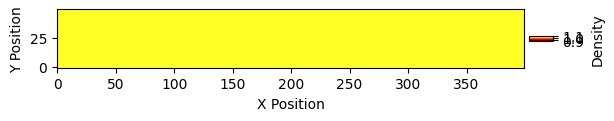

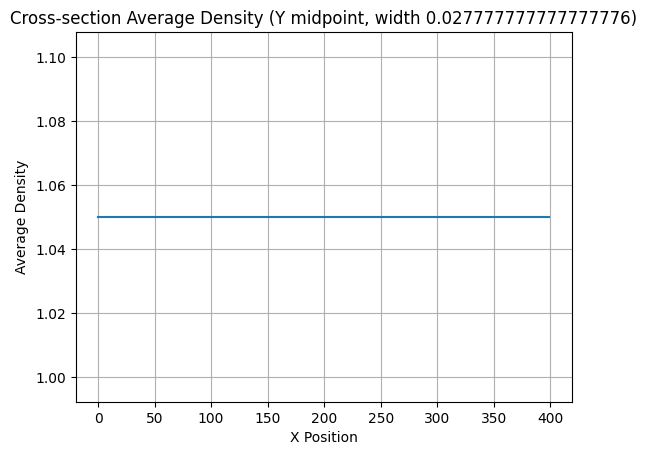

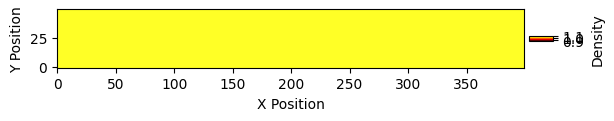

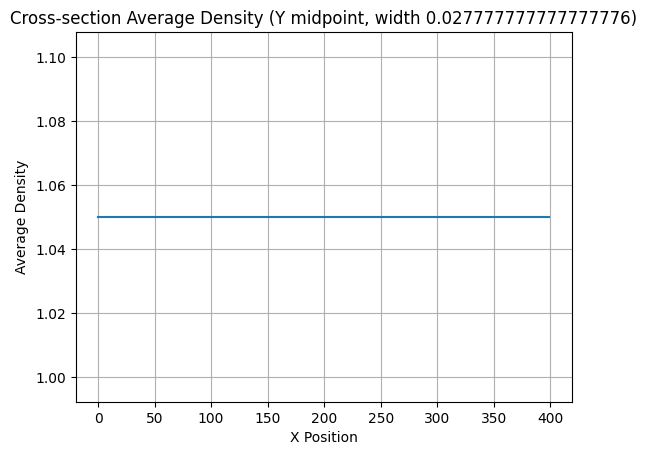

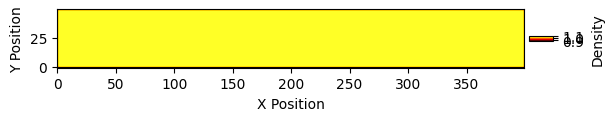

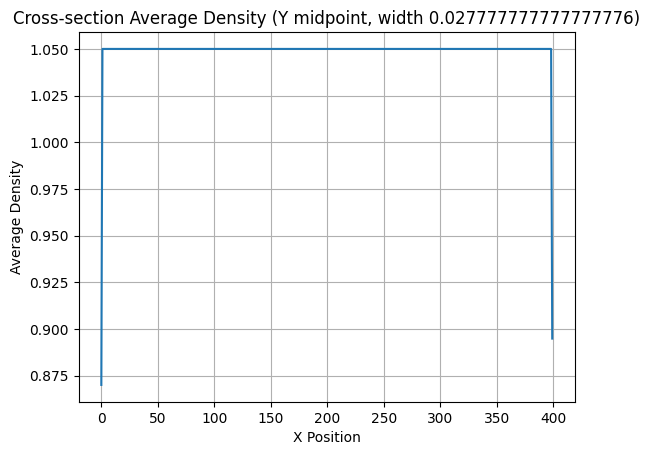

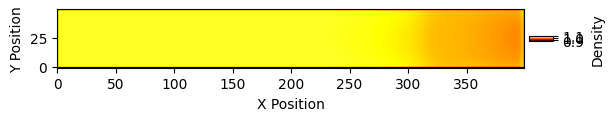

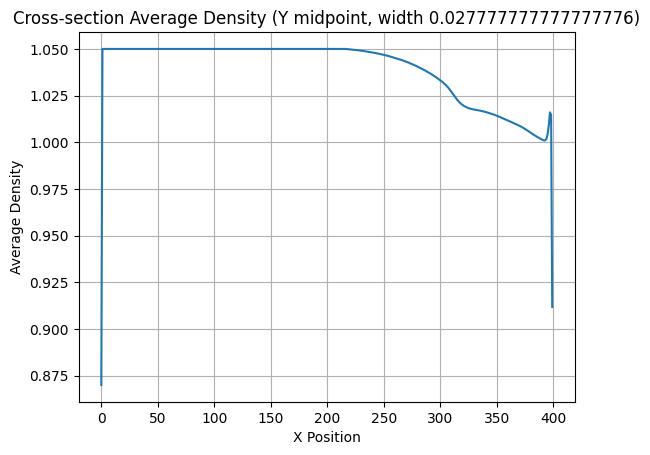

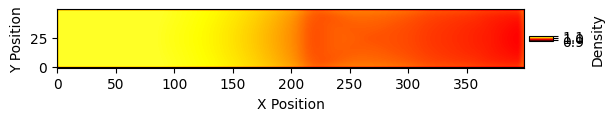

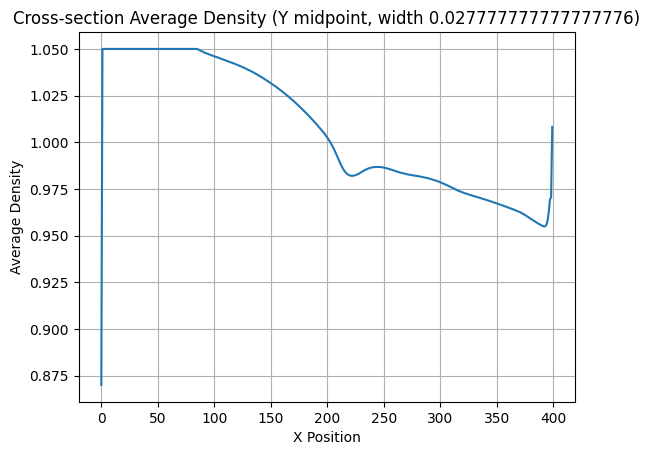

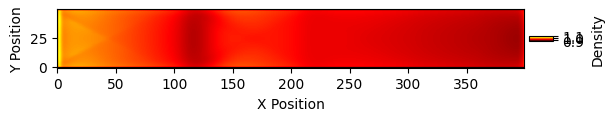

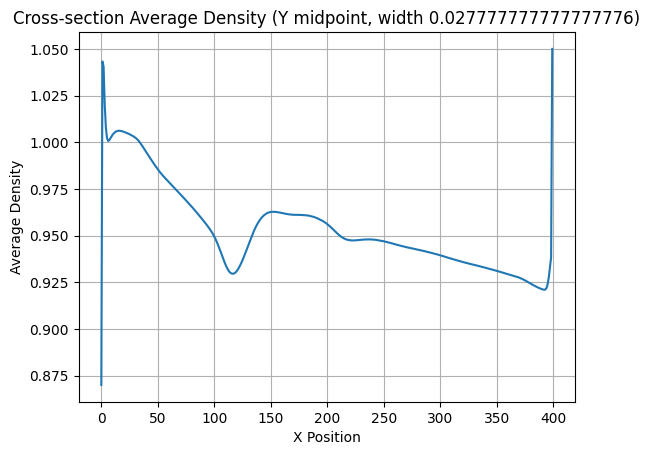

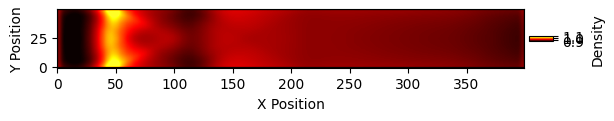

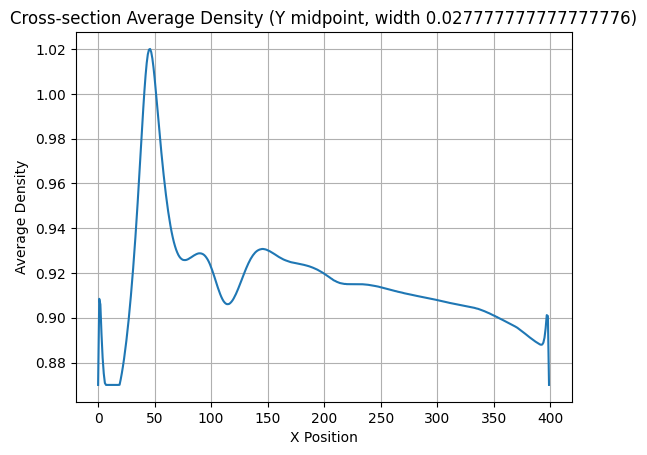

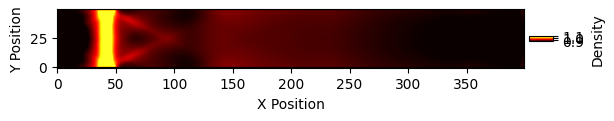

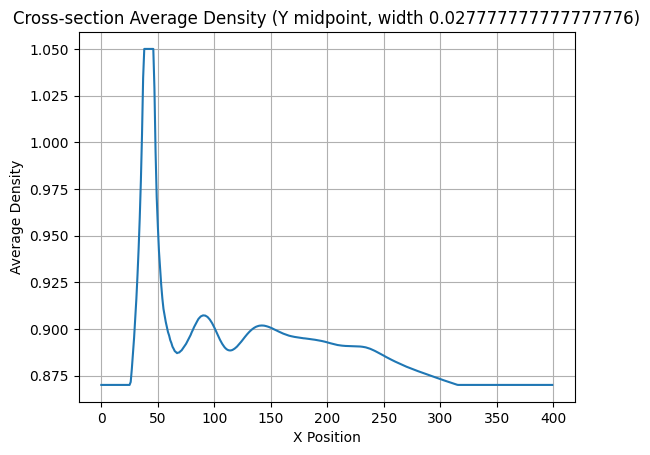

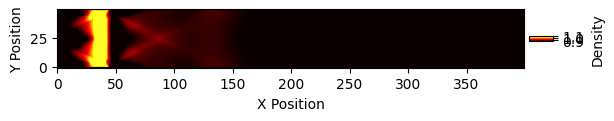

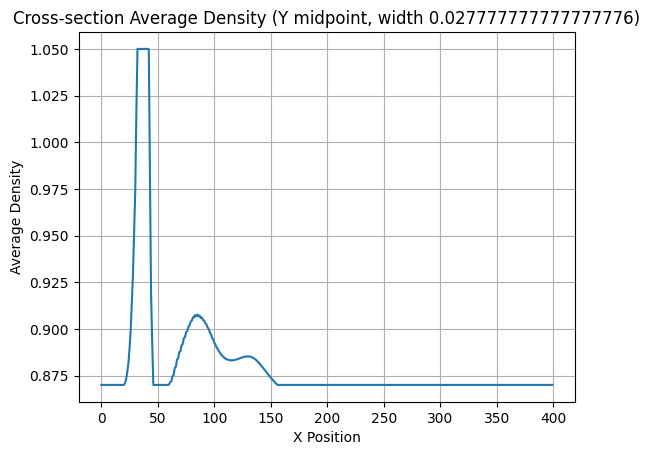

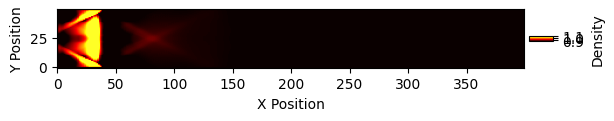

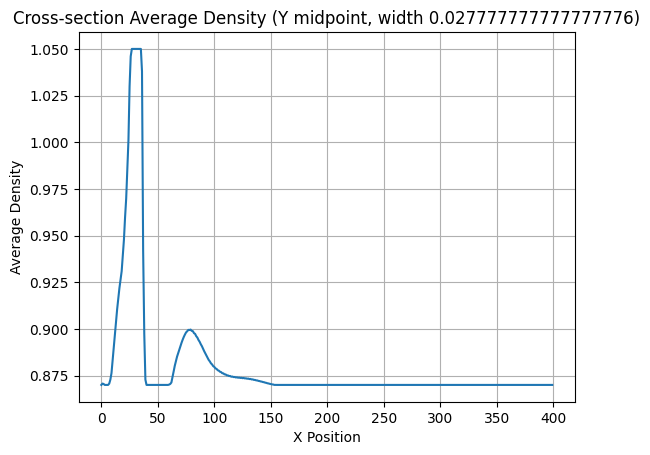

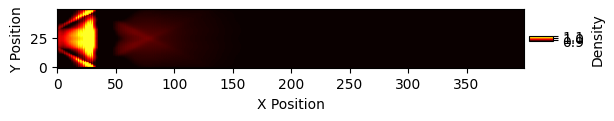

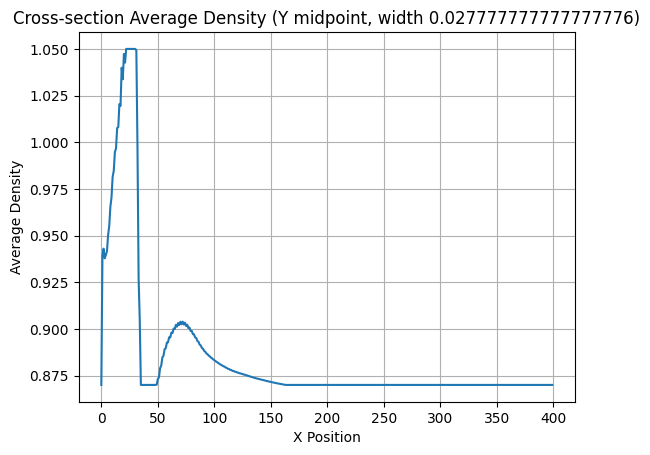

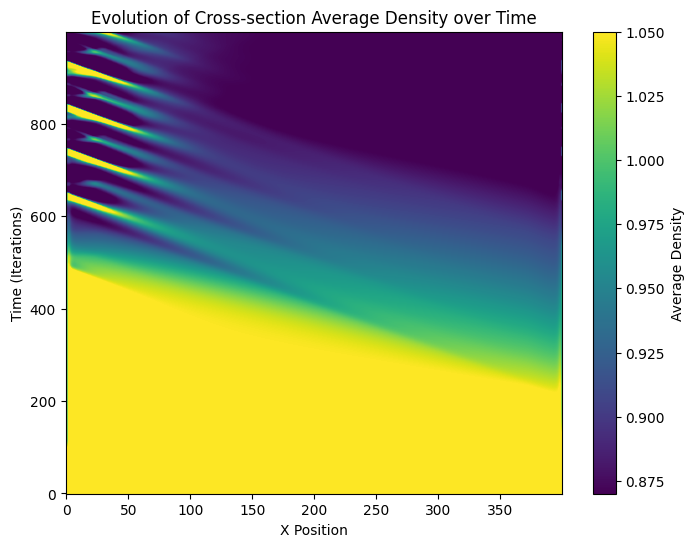

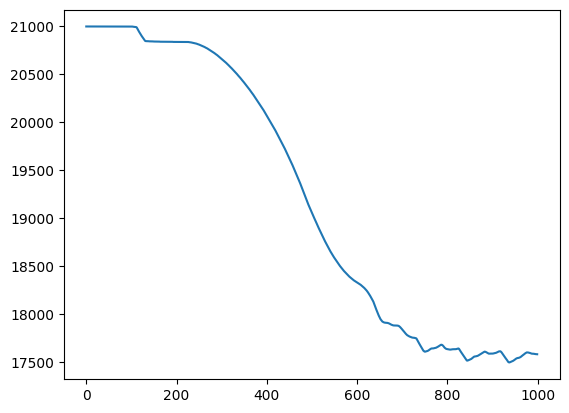

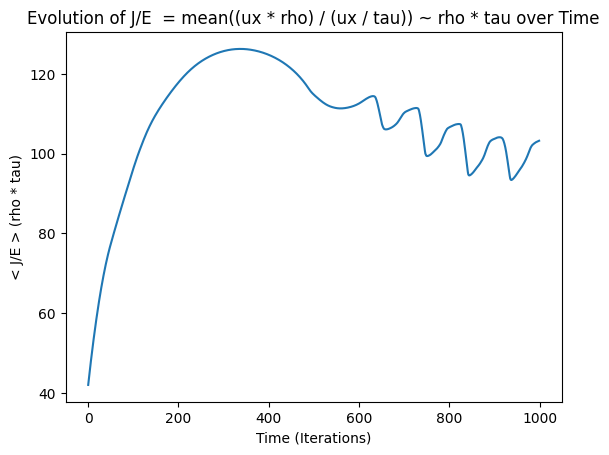

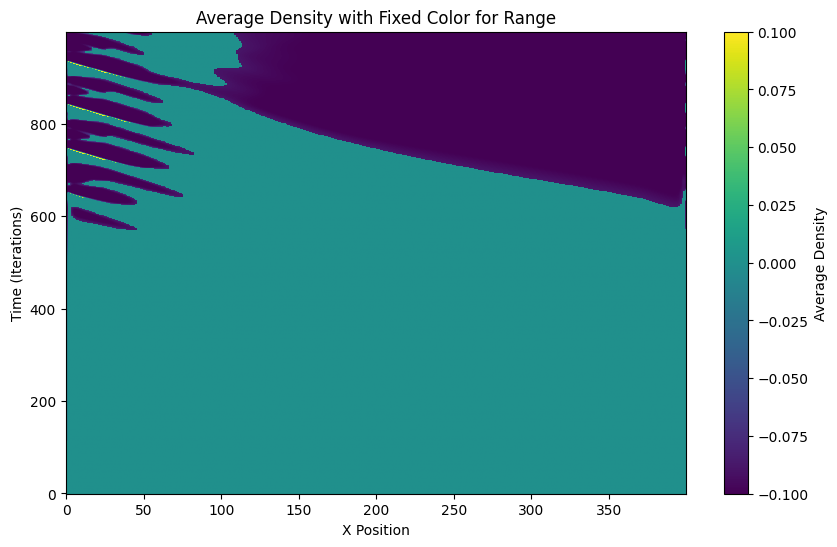

In [575]:
for it in range (Nt):
    ############## Drift ########################  
    for i, cx, cy in zip(idxs, cxs, cys):
        F[:, :, i] = np.roll(F[:, :, i], cx, axis=1)
        F[:, :, i] = np.roll(F[:, :, i], cy, axis=0)
    
    
    ############### Set reflective boundaries ################
 
    # # 경계에서의 밀도 값을 보정
    # #rho[:, 0] = rho[:, 1]  # 왼쪽 경계 밀도를 내부 첫 번째 열과 동일하게 유지
    # #rho[:, -1] = rho[:, -2]  # 오른쪽 경계 밀도를 내부 마지막 열과 동일하게 유지
    # #rho[0, :] = rho[1, :]  # 상단 경계 밀도를 내부 첫 번째 행과 동일하게 유지
    # #rho[-1, :] = rho[-2, :]  # 하단 경계 밀도를 내부 마지막 행과 동일하게 유지
    # # Inflow condition: Specify constant density or velocity at the left boundary (X = 0)
    # ux_in = 0.1  # Inflow velocity in x direction
    # rho_in = 1.0  # Inflow density

    # for i, cx, cy, w in zip(idxs, cxs, cys, weights):
    #     Feq[:, 0, i] = rho_in * w * (
    #                 1 + 3 * (cx * ux_in + cy * 0) + 9 * (cx * ux_in + cy * 0) ** 2 / 2 - 3 * (ux_in ** 2 + 0) / 2)
    #     F[:, 0, i] = Feq[:, 0, i]
    # Apply reflection with momentum damping at boundaries
    
    apply_reflection_with_damping(F)
    
    ############### Calculate fluid variables ################
    rho = np.sum(F, 2)
#    rho = phase_transition(F, rho, rho_lower, rho_upper)

    
    # Clipping: Restrict rho within the specified bounds
    rho = np.clip(rho, rho_lower, rho_upper)  # Clip rho between rho_min and rho_max
    
    # Global scaling: Normalize total mass (or density) to keep it constant
    # total_mass = np.sum(rho)
    # scaling_factor = initial_total_mass / total_mass  # Compute scaling factor
    # rho *= scaling_factor  # Apply scaling to keep total mass constant
    
    ux = np.sum(F * cxs, 2) / rho
    uy = np.sum(F * cys, 2) / rho

    ################### tau는 속도 sqrt(ux^2+uy^2)에 의존성을 가짐 ####################
    # tau_local = adjust_tau_based_on_multiple_velocities(ux, uy, tau=tau, speed_thresholds=speed_thresholds, tau_factors=tau_factors)
    # tau = tau_local

    
    # Clip ux and uy to avoid overflow
    ux = np.clip(ux, -10, 10)  # Clip to a reasonable range
    uy = np.clip(uy, -10, 10)  # Clip to a reasonable range
    
    ux = apply_global_smoothing(ux, s_size)  # Smooth ux
    uy = apply_global_smoothing(uy, s_size/4)  # Smooth uy

    ################### 밀도 조건 #################
    enforce_density_limits(F, rho, rho_lower, rho_upper, Feq, idxs)
    apply_boundary_conditions(F)
    
    #################### 전기장 ###################
    #conductivity = k * rho  # or any other relation for conductivity
    # 전기장 추가 (푸아송 방정식 해법을 이용한)
    #Ex_field, Ey_field = poisson_solve(rho, conductivity, Nx, Ny)
    #ux = np.sum(F * cxs, 2) / rho + Ex_field / tau
    #uy = np.sum(F * cys, 2) / rho + Ey_field / tau

    ux, E = apply_electric_field(ux, rho, E0, rho_lower, rho_upper, tau, Nx, V_applied, it+1)

    # Compute local velocity gradients (shear rate) if using velocity-dependent tau
    duy_dx = np.gradient(uy, axis=1)  # du_y/dx
    dux_dy = np.gradient(ux, axis=0)  # du_x/dy
    shear_rate = np.abs(dux_dy - duy_dx)
    
    ################### 충돌 #######################
    # Apply Collision
    Feq = np.zeros(F.shape)
    for i, cx, cy, w in zip(idxs, cxs, cys, weights):
        # Local adaptive tau based on density (or shear rate)
        local_tau = tau0 * (1 + alpha * (rho - rho0) / rho0 + beta * shear_rate)
     
        Feq[:, :, i] = rho * w * (
                    1 + 3 * (cx * ux + cy * uy) + 9 * (cx * ux + cy * uy) ** 2 / 2 - 3 * (ux ** 2 + uy ** 2) / 2)
        
        F[:,:,i] += -(1.0 / local_tau) * (F[:,:,i] - Feq[:,:,i])

    rho = np.round(rho,4)
    ux = np.round(ux,4)
    uy = np.round(uy,4)
    # rho = phase_transition(F, rho, rho_lower, rho_upper)

    ################## 이미지 후처리 #################
    # Store cross-section data for this iteration
    cross_section_avg = np.mean(rho[max(0, y_mid - width // 2):min(Ny, y_mid + width // 2), :], axis=0)
    cross_section_data[it, :] = cross_section_avg  # Store the cross-section data

    sigma_data[it] = calculate_global_conductivity(E, rho, ux)
    
    plot_real_time(rho, bd, y_mid, width, it, Nt, plotRealTime)


    
    
    # 현재 밀도 총합 계산
    current_total_density = np.round(np.sum(rho),0)
    density_data[it] = current_total_density
    # 차이 계산
    density_diff = np.round(initial_total_density - current_total_density, 0)
    # 밀도 차이에 따라 보정 비율 계산
    correction_factor = np.round(density_diff / np.size(rho), 0) / 9
    # 밀도 보정 적용
    rho_corrected = rho + correction_factor
    # F *= rho_corrected[..., np.newaxis] / rho[..., np.newaxis]
    rho = rho_corrected


# After all iterations, plot the colormap for cross-section data over time
plt.figure(figsize=(8, 6))
plt.imshow(cross_section_data, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Average Density')
plt.title('Evolution of Cross-section Average Density over Time')
plt.xlabel('X Position')
plt.ylabel('Time (Iterations)')
plt.grid(False)


current_time = datetime.now().strftime('%Y%m%d_%H%M%S')  # 'YYYYMMDD_HHMMSS' 형식
filename = f"plot_{current_time}_time_{tau}_V_{V_applied}.png"
plt.savefig(filename)

# Show the final colormap
plt.show()

plt.figure()
plt.plot(density_data)
plt.show()

plt.figure()
plt.plot(sigma_data)
plt.title('Evolution of J/E  = mean((ux * rho) / (ux / tau)) ~ rho * tau over Time')
plt.xlabel('Time (Iterations)')
plt.ylabel('< J/E > (rho * tau)')
plt.grid(False)
plt.savefig(filename.strip(".png")+"_sigma.png")
plt.show()

save_cross_section_data(cross_section_data, current_time, tau)


# 평균 밀도 값 범위를 설정합니다
density_min = 0.88
density_max = 1.3

# 밀도가 설정된 범위에 있을 때의 색상 고정을 위해 마스크를 만듭니다
masked_density = np.ma.masked_where((cross_section_data < density_min) | (cross_section_data > density_max), cross_section_data)
# 색상 맵을 생성하고 색상을 고정합니다
plt.figure(figsize=(10, 6))
im = plt.imshow(cross_section_data, aspect='auto', cmap='viridis', origin='lower')
im = plt.imshow(cross_section_data - masked_density, aspect='auto', cmap='viridis', origin='lower')

# 색상 막대를 추가합니다
cbar = plt.colorbar(im)
cbar.set_label('Average Density')

# 플롯의 제목과 축 레이블 추가
plt.title('Average Density with Fixed Color for Range')
plt.xlabel('X Position')
plt.ylabel('Time (Iterations)')

plt.grid(False)

filename2 = f"plot_{current_time}_time_{tau}_V_{V_applied}_cmap.png"
plt.savefig(filename2)
plt.show()

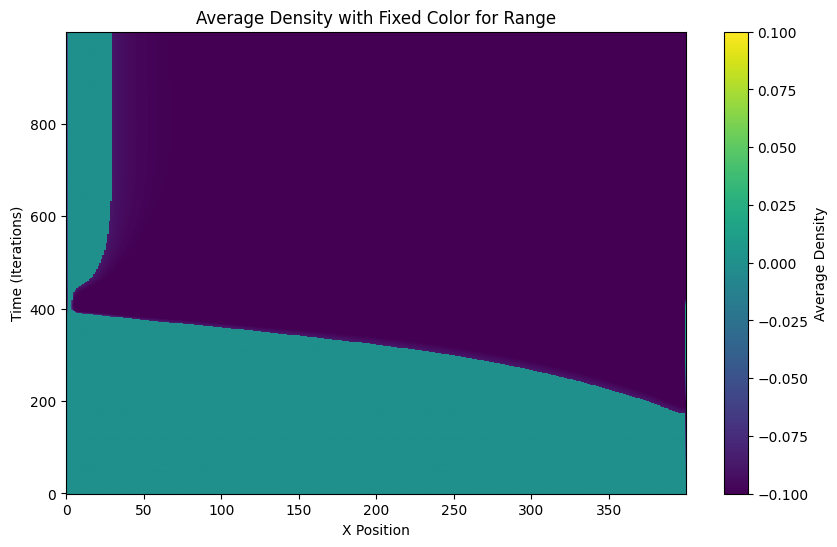

In [523]:
# 평균 밀도 값 범위를 설정합니다
density_min = 0.88
density_max = 1.3

# 밀도가 설정된 범위에 있을 때의 색상 고정을 위해 마스크를 만듭니다
masked_density = np.ma.masked_where((cross_section_data < density_min) | (cross_section_data > density_max), cross_section_data)
# 색상 맵을 생성하고 색상을 고정합니다
plt.figure(figsize=(10, 6))
im = plt.imshow(cross_section_data, aspect='auto', cmap='viridis', origin='lower')
im = plt.imshow(cross_section_data - masked_density, aspect='auto', cmap='viridis', origin='lower')

# 색상 막대를 추가합니다
cbar = plt.colorbar(im)
cbar.set_label('Average Density')

# 플롯의 제목과 축 레이블 추가
plt.title('Average Density with Fixed Color for Range')
plt.xlabel('X Position')
plt.ylabel('Time (Iterations)')

plt.grid(False)
plt.show()


In [302]:
initial_total_density, current_total_density, np.sum(rho)

(np.float64(180000.0), np.float64(19596.0), np.float64(39595.83860000001))